# Кластеризация с использованием графовых эмбеддингов

## Установка необходимых библиотек

In [ ]:
!pip install tensorflow==2.9.0 ampligraph==2.0.1

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 511.7/511.7 MB 3.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 204.0/204.0 kB 18.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 53.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 6.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 46.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 438.7/438.7 kB 30.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.8/57.8 kB 2.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 575.5/575.5 kB 28.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.8/2.8 MB 39.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 531.9/531.9 kB 19.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.4/34.4 MB 24.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 9.0 MB/s eta 0:00:00
  Preparing metadata (setup.

In [ ]:
import numpy as np
import pandas as pd
import ampligraph


In [ ]:
import tensorflow as tf

tf.test.is_gpu_available()

True

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Загрузка данных

### Данные о сериалах и фильмах

In [ ]:
DATA_PATH = '/content/drive/MyDrive/graphs_course'
titles_data = pd.read_csv(f'{DATA_PATH}/titles_full.csv')
credits_data = pd.read_csv(f'{DATA_PATH}/credits_full.csv')
demography_data = pd.read_csv(f'{DATA_PATH}/demography.csv')

In [ ]:
print(titles_data.info())
titles_data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19015 entries, 0 to 19014
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   id                    19015 non-null  object 
 1   streaming             19015 non-null  object 
 2   title                 19014 non-null  object 
 3   type                  19015 non-null  object 
 4   release_year          19015 non-null  int64  
 5   age_certification     8700 non-null   object 
 6   runtime               19015 non-null  int64  
 7   genres                19015 non-null  object 
 8   production_countries  19015 non-null  object 
 9   seasons               4219 non-null   float64
 10  imdb_score            17141 non-null  float64
 11  tmdb_score            16354 non-null  float64
dtypes: float64(3), int64(2), object(7)
memory usage: 1.7+ MB
None


,id,streaming,title,type,release_year,age_certification,runtime,genres,production_countries,seasons,imdb_score,tmdb_score
0,ts300399,Netflix,Five Came Back: The Reference Films,SHOW,1945,TV-MA,51,['documentation'],['US'],1.0,NaN,NaN
1,tm84618,Netflix,Taxi Driver,MOVIE,1976,R,114,"['drama', 'crime']",['US'],NaN,8.2,8.179
2,tm154986,Netflix,Deliverance,MOVIE,1972,R,109,"['drama', 'action', 'thriller', 'european']",['US'],NaN,7.7,7.300
3,tm127384,Netflix,Monty Python and the Holy Grail,MOVIE,1975,PG,91,"['fantasy', 'action', 'comedy']",['GB'],NaN,8.2,7.811
4,tm120801,Netflix,The Dirty Dozen,MOVIE,1967,NaN,150,"['war', 'action']","['US', 'GB']",NaN,7.7,7.600


In [ ]:
# Проверим, что кол-во сезонов есть у всех шоу и нет у фильмов
print(len(titles_data.loc[(titles_data['type'] == 'SHOW') & (titles_data['seasons'].notna())]))
print(len(titles_data.loc[(titles_data['type'] == 'MOVIE') & (titles_data['seasons'].notna())]))

4219
0


In [ ]:
# удалим из выборки фильмы, у которых нет рейтинга
titles_data = titles_data.loc[titles_data['tmdb_score'].notna()]
titles_data = titles_data.loc[titles_data['imdb_score'].notna()]
titles_data.isna().sum()

id                          0
streaming                   0
title                       0
type                        0
release_year                0
age_certification        7381
runtime                     0
genres                      0
production_countries        0
seasons                 11854
imdb_score                  0
tmdb_score                  0
dtype: int64

In [ ]:
# заполним пропуски в столбце с возростным рейтингом
titles_data['age_certification'] = titles_data['age_certification'].fillna('NoRating')
display(titles_data.loc[titles_data['age_certification'] == 'NoRating'].head())
titles_data.isna().sum()

,id,streaming,title,type,release_year,age_certification,runtime,genres,production_countries,seasons,imdb_score,tmdb_score
4,tm120801,Netflix,The Dirty Dozen,MOVIE,1967,NoRating,150,"['war', 'action']","['US', 'GB']",NaN,7.7,7.6
10,tm44204,Netflix,The Guns of Navarone,MOVIE,1961,NoRating,158,"['action', 'drama', 'war']","['GB', 'US']",NaN,7.5,7.3
13,tm16479,Netflix,White Christmas,MOVIE,1954,NoRating,115,"['romance', 'comedy']",['US'],NaN,7.5,7.2
14,tm135083,Netflix,Cairo Station,MOVIE,1958,NoRating,77,"['drama', 'crime', 'comedy']",['EG'],NaN,7.5,7.3
17,tm14350,Netflix,Alexandria… Why?,MOVIE,1979,NoRating,133,['drama'],['EG'],NaN,7.2,6.0


id                          0
streaming                   0
title                       0
type                        0
release_year                0
age_certification           0
runtime                     0
genres                      0
production_countries        0
seasons                 11854
imdb_score                  0
tmdb_score                  0
dtype: int64

In [ ]:
display(titles_data[titles_data['genres'] == '[]'])
display(titles_data[titles_data['production_countries'] == '[]'])

,id,streaming,title,type,release_year,age_certification,runtime,genres,production_countries,seasons,imdb_score,tmdb_score
1813,ts77824,Netflix,My Next Guest Needs No Introduction With David...,SHOW,2018,TV-MA,50,[],['US'],4.0,7.8,7.6
2386,ts74805,Netflix,A Little Help with Carol Burnett,SHOW,2018,TV-G,24,[],['US'],1.0,6.3,6.2
6232,tm83465,Amazon,Sunny,MOVIE,1941,NoRating,98,[],['US'],NaN,5.4,6.0
6490,tm1733,Amazon,Adventure in Iraq,MOVIE,1943,NoRating,65,[],['US'],NaN,5.0,6.0
6544,tm4340,Amazon,Career Girl,MOVIE,1944,NoRating,69,[],['US'],NaN,5.5,5.0
7640,tm769574,Amazon,Bhalu,MOVIE,1980,NoRating,134,[],['IN'],NaN,6.5,5.0
7992,tm136989,Amazon,Enna Petha Raasa,MOVIE,1989,NoRating,137,[],['IN'],NaN,5.7,5.0
8500,tm256686,Amazon,Don't Leave Me This Way,MOVIE,1993,NoRating,133,[],['GB'],NaN,6.3,8.0
9748,tm149861,Amazon,Gaiir,MOVIE,2009,NoRating,147,[],['XX'],NaN,6.4,5.0
9838,tm482980,Amazon,Chakwa,MOVIE,2004,NoRating,125,[],['IN'],NaN,6.7,8.0


,id,streaming,title,type,release_year,age_certification,runtime,genres,production_countries,seasons,imdb_score,tmdb_score
26,ts45948,Netflix,Monty Python's Fliegender Zirkus,SHOW,1972,TV-MA,43,['comedy'],[],1.0,8.1,7.0
1949,ts83455,Netflix,Wanderlust,SHOW,2018,TV-MA,57,['drama'],[],1.0,7.0,6.5
2018,tm356742,Netflix,Trolls Holiday,MOVIE,2017,PG,26,"['fantasy', 'comedy', 'family', 'romance', 'an...",[],NaN,6.1,6.7
2032,ts87043,Netflix,Transformers: Rescue Bots Academy,SHOW,2018,TV-Y,12,"['animation', 'comedy', 'family', 'scifi', 'ac...",[],2.0,6.2,10.0
2327,tm375302,Netflix,Derren Brown: The Push,MOVIE,2018,NoRating,69,"['reality', 'documentation']",[],NaN,7.5,7.5
...,...,...,...,...,...,...,...,...,...,...,...,...
18922,tm1171915,HBO,Drew Michael: Red Blue Green,MOVIE,2021,NoRating,58,['comedy'],[],NaN,7.0,6.0
18962,tm1017409,HBO,Pure,MOVIE,2021,NoRating,12,['romance'],[],NaN,7.0,1.0
18985,tm1131113,HBO,"Diego, The Last Goodbye",MOVIE,2021,PG-13,89,['documentation'],[],NaN,5.9,6.0
18986,tm1128515,HBO,Single Mother by Choice,MOVIE,2021,NoRating,82,['drama'],[],NaN,2.6,7.5


In [ ]:
titles_data = titles_data[titles_data['genres'] != '[]']
titles_data = titles_data[titles_data['production_countries'] != '[]']

In [ ]:
# проверим есть ли полные дубликаты
titles_data[titles_data.duplicated()]

,id,streaming,title,type,release_year,age_certification,runtime,genres,production_countries,seasons,imdb_score,tmdb_score
6330,tm89134,Amazon,The Gunman From Bodie,MOVIE,1941,NoRating,62,['western'],['US'],NaN,5.9,7.0


In [ ]:
titles_data.drop_duplicates(inplace=True)

In [ ]:
titles_data['release_year'].sort_values().unique()

array([1912, 1914, 1915, 1916, 1917, 1918, 1919, 1920, 1921, 1922, 1923,
       1924, 1925, 1926, 1927, 1928, 1929, 1930, 1931, 1932, 1933, 1934,
       1935, 1936, 1937, 1938, 1939, 1940, 1941, 1942, 1943, 1944, 1945,
       1946, 1947, 1948, 1949, 1950, 1951, 1952, 1953, 1954, 1955, 1956,
       1957, 1958, 1959, 1960, 1961, 1962, 1963, 1964, 1965, 1966, 1967,
       1968, 1969, 1970, 1971, 1972, 1973, 1974, 1975, 1976, 1977, 1978,
       1979, 1980, 1981, 1982, 1983, 1984, 1985, 1986, 1987, 1988, 1989,
       1990, 1991, 1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000,
       2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011,
       2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022])

In [ ]:
titles_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14908 entries, 1 to 19011
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   id                    14908 non-null  object 
 1   streaming             14908 non-null  object 
 2   title                 14908 non-null  object 
 3   type                  14908 non-null  object 
 4   release_year          14908 non-null  int64  
 5   age_certification     14908 non-null  object 
 6   runtime               14908 non-null  int64  
 7   genres                14908 non-null  object 
 8   production_countries  14908 non-null  object 
 9   seasons               3304 non-null   float64
 10  imdb_score            14908 non-null  float64
 11  tmdb_score            14908 non-null  float64
dtypes: float64(3), int64(2), object(7)
memory usage: 1.5+ MB


### Данные об актерах

In [ ]:
print(credits_data.info())
credits_data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 268429 entries, 0 to 268428
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   person_id     268429 non-null  object
 1   id            268429 non-null  object
 2   character     237865 non-null  object
 3   character_id  268429 non-null  object
 4   role          268429 non-null  object
 5   name          268429 non-null  object
dtypes: object(6)
memory usage: 12.3+ MB
None


,person_id,id,character,character_id,role,name
0,p3748,tm84618,Travis Bickle,ch0,ACTOR,Robert De Niro
1,p14658,tm84618,Iris Steensma,ch1,ACTOR,Jodie Foster
2,p7064,tm84618,Tom,ch2,ACTOR,Albert Brooks
3,p3739,tm84618,Matthew 'Sport' Higgins,ch3,ACTOR,Harvey Keitel
4,p48933,tm84618,Betsy,ch4,ACTOR,Cybill Shepherd


In [ ]:
# удалим пропуски
credits_data.dropna(inplace=True)

In [ ]:
# проверим есть ли полные дубликаты дубликаты
credits_data[credits_data.duplicated()]

,person_id,id,character,character_id,role,name
86957,p130904,tm89134,Buck Roberts,ch74687,ACTOR,Buck Jones
86958,p36589,tm89134,Marshal McCall,ch74688,ACTOR,Tim McCoy
86959,p130905,tm89134,Sandy,ch74689,ACTOR,Raymond Hatton
86960,p132916,tm89134,Alice Borden,ch74690,ACTOR,Christine McIntyre
86961,p132381,tm89134,Joe Martin,ch74691,ACTOR,Dave O'Brien
...,...,...,...,...,...,...
261716,p736652,ts107109,Funshine Bear / Gus / Malcolm (voice),ch156009,ACTOR,Justin Michael
261717,p822934,ts107109,Bedtime Bear / Garath (voice),ch156010,ACTOR,Harry Chaskin
261718,p658807,ts107109,Good Luck Bear (voice),ch156011,ACTOR,Patrick Pedraza
261719,p93060,ts107109,Wish Bear (voice),ch156012,ACTOR,Valarie Rae Miller


In [ ]:
credits_data.drop_duplicates(inplace=True)

In [ ]:
credits_data[credits_data.duplicated(['person_id', 'id'])]

,person_id,id,character,character_id,role,name
100,p11475,tm127384,Themselves (uncredited),ch82,ACTOR,Terry Jones
1306,p479070,tm126769,Policía\t- Compañero de Peralta.,ch1124,ACTOR,José Andrada
4302,p135051,tm52083,Riad Noueri - Tarek' father,ch3805,ACTOR,Carmen Lebbos
6390,p61324,tm30603,Executive,ch5659,ACTOR,Trieu Tran
7112,p39337,ts35155,Leite Jokin (voice),ch6257,ACTOR,Takako Honda
...,...,...,...,...,...,...
263992,p119746,tm1020165,Arresting ICE Agent,ch224499,ACTOR,Brandi Price
265508,p1815379,tm239632,Otto's Entourage (uncredited),ch225805,ACTOR,Méghane De Croock
265509,p1147956,tm239632,Sergeant Reyes (uncredited),ch225806,ACTOR,Lex Elle
266736,p1903304,tm350225,Self (Archival Footage),ch226885,ACTOR,Joe Raposo


In [ ]:
credits_data[credits_data['person_id']=='p11475']

,person_id,id,character,character_id,role,name
64,p11475,tm127384,Dennis's Mother / Sir Bedevere / Left Head / P...,ch63,ACTOR,Terry Jones
100,p11475,tm127384,Themselves (uncredited),ch82,ACTOR,Terry Jones
165,p11475,ts22164,Various,ch137,ACTOR,Terry Jones
172,p11475,tm70993,Mandy Cohen / Colin / Simon the Holy Man / Bob...,ch143,ACTOR,Terry Jones
518,p11475,ts45948,Various Characters,ch406,ACTOR,Terry Jones
1330,p11475,tm62924,Various Roles,ch1144,ACTOR,Terry Jones
1384,p11475,tm133914,Himself,ch1186,ACTOR,Terry Jones
4190,p11475,tm57169,Self,ch3714,ACTOR,Terry Jones
4362,p11475,tm34391,Himself,ch3849,ACTOR,Terry Jones
9204,p11475,ts23808,Himself,ch8100,ACTOR,Terry Jones


Один и тот же актер может играть разных персонажей в одном фильме, поэтому такие случаи удалять не будем

In [ ]:
credits_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 233889 entries, 0 to 268426
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   person_id     233889 non-null  object
 1   id            233889 non-null  object
 2   character     233889 non-null  object
 3   character_id  233889 non-null  object
 4   role          233889 non-null  object
 5   name          233889 non-null  object
dtypes: object(6)
memory usage: 12.5+ MB


### Демографические данные

In [ ]:
print(demography_data.info())
demography_data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28 entries, 0 to 27
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   year              28 non-null     int64  
 1   npg               28 non-null     float64
 2   birth_rate        28 non-null     float64
 3   death_rate        28 non-null     float64
 4   migratory_growth  21 non-null     float64
 5   population        28 non-null     float64
dtypes: float64(5), int64(1)
memory usage: 1.4 KB
None


,year,npg,birth_rate,death_rate,migratory_growth,population
0,1990,3.812195,14.354878,10.542683,NaN,1.766162e+06
1,1991,2.196341,12.971951,10.775610,NaN,1.786431e+06
2,1992,-0.108537,11.479268,11.587805,NaN,1.789334e+06
3,1993,-3.786420,10.046913,13.833333,NaN,1.789900e+06
4,1994,-4.781481,10.228395,15.009876,NaN,1.787420e+06


In [ ]:
demography_data['year'].unique()

array([1990, 1991, 1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000,
       2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011,
       2012, 2013, 2014, 2015, 2016, 2017])

### Смержим все в одну таблицу, чтобы затем было проще сделать триплеты

In [ ]:
full_data = credits_data.merge(titles_data, on='id')
#full_data = full_data.merge(demography_data[['year','birth_rate', 'death_rate']],
                            #left_on='release_year', right_on='year')
print(full_data.info())
full_data.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 219299 entries, 0 to 219298
Data columns (total 17 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   person_id             219299 non-null  object 
 1   id                    219299 non-null  object 
 2   character             219299 non-null  object 
 3   character_id          219299 non-null  object 
 4   role                  219299 non-null  object 
 5   name                  219299 non-null  object 
 6   streaming             219299 non-null  object 
 7   title                 219299 non-null  object 
 8   type                  219299 non-null  object 
 9   release_year          219299 non-null  int64  
 10  age_certification     219299 non-null  object 
 11  runtime               219299 non-null  int64  
 12  genres                219299 non-null  object 
 13  production_countries  219299 non-null  object 
 14  seasons               21350 non-null   float64
 15  

,person_id,id,character,character_id,role,name,streaming,title,type,release_year,age_certification,runtime,genres,production_countries,seasons,imdb_score,tmdb_score
0,p3748,tm84618,Travis Bickle,ch0,ACTOR,Robert De Niro,Netflix,Taxi Driver,MOVIE,1976,R,114,"['drama', 'crime']",['US'],NaN,8.2,8.179
1,p14658,tm84618,Iris Steensma,ch1,ACTOR,Jodie Foster,Netflix,Taxi Driver,MOVIE,1976,R,114,"['drama', 'crime']",['US'],NaN,8.2,8.179
2,p7064,tm84618,Tom,ch2,ACTOR,Albert Brooks,Netflix,Taxi Driver,MOVIE,1976,R,114,"['drama', 'crime']",['US'],NaN,8.2,8.179
3,p3739,tm84618,Matthew 'Sport' Higgins,ch3,ACTOR,Harvey Keitel,Netflix,Taxi Driver,MOVIE,1976,R,114,"['drama', 'crime']",['US'],NaN,8.2,8.179
4,p48933,tm84618,Betsy,ch4,ACTOR,Cybill Shepherd,Netflix,Taxi Driver,MOVIE,1976,R,114,"['drama', 'crime']",['US'],NaN,8.2,8.179


In [ ]:
full_data[full_data.duplicated()]

,person_id,id,character,character_id,role,name,streaming,title,type,release_year,age_certification,runtime,genres,production_countries,seasons,imdb_score,tmdb_score


In [ ]:
for _, row in full_data.iterrows():
  genres = row["genres"][1:-1].replace("'", "").split(', ')
    for genre in genres:

12

После предобработки осталось меньше данных, тк в демографических данных меньше годов, чем в годов выпусков фильмов, однако для экспериментов с эмбеддингами нам этого вполне хватит.

## Создадим граф знаний (триплеты)

In [ ]:
triples = []
for _, row in full_data.iterrows():
    streaming = (row["id"], "availableOn", row["streaming"])
    release_year = (row["id"], "releasedIn", row["release_year"])
    age_rating = (row["id"], "hasAgeRating", row["age_certification"])
    imdb_rating = (row["id"], "hasIMDBrating", row["imdb_score"])
    tmdb_rating = (row["id"], "hasTMDBrating", row["tmdb_score"])
    character_in_film_product = (row["character_id"], "appearedIn", row["id"])

    triples.extend((streaming, release_year, age_rating, imdb_rating,
                    tmdb_rating,
                    character_in_film_product))

    production_countries = row["production_countries"][1:-1].replace("'", "").split(', ')
    for country in production_countries:
      production_country = (row["id"], "producedIn", country)
      triples.append(production_country)

    genres = row["genres"][1:-1].replace("'", "").split(', ')
    for genre in genres:
      genre_of_film_product = (row["id"], "hasGenre", genre)
      triples.append(genre_of_film_product)

    if row['type'] == 'SHOW':
      duraction_of_episode = (row["id"], "duractionOfEpisode", row["runtime"])
      number_of_seasons = (row["id"], "numberOfSeasons", row["seasons"])
      triples.extend((duraction_of_episode, number_of_seasons))
    elif row['type'] == 'MOVIE':
      duraction_of_movie = (row["id"], "duraction", row["runtime"])
      triples.append(tuple(duraction_of_movie))

    if row['role'] == 'ACTOR':
      actors_in_film_product = (row["person_id"], "actedIn", row["id"])
      actors_played_characters = (row["person_id"], "playRoleOf", row["character_id"])
      triples.extend((actors_in_film_product, actors_played_characters))
    elif row['role'] == 'DIRECTOR':
      dicrectors_in_film_product = (row["person_id"], "dicrected", row["id"])
      triples.append(tuple(dicrectors_in_film_product))

In [ ]:
triples_df = pd.DataFrame(triples, columns=["subject", "predicate", "object"])
triples_df[(triples_df.subject=="p6638") | (triples_df.object=="p6638")]

,subject,predicate,object
19911,p6638,actedIn,tm152839
19912,p6638,playRoleOf,ch1126
19923,p6638,actedIn,tm152839
19924,p6638,playRoleOf,ch1126
64589,p6638,actedIn,tm7951
64590,p6638,playRoleOf,ch3796
64601,p6638,actedIn,tm7951
64602,p6638,playRoleOf,ch3796
138260,p6638,actedIn,tm86995
138261,p6638,playRoleOf,ch8055


In [ ]:
triples_df.head()

,subject,predicate,object
0,tm84618,availableOn,Netflix
1,tm84618,releasedIn,1976
2,tm84618,hasAgeRating,R
3,tm84618,hasIMDBrating,8.2
4,tm84618,hasTMDBrating,8.179


In [ ]:
# удалим повторяющиеся триплеты
triples = list(set(triples))
triples_df = pd.DataFrame(triples, columns=["subject", "predicate", "object"])
triples_df[triples_df.duplicated()]

,subject,predicate,object


In [ ]:
print(triples_df.info())
triples_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 762685 entries, 0 to 762684
Data columns (total 3 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   subject    762685 non-null  object
 1   predicate  762685 non-null  object
 2   object     762685 non-null  object
dtypes: object(3)
memory usage: 17.5+ MB
None


,subject,predicate,object
0,ch186876,appearedIn,tm21058
1,ts37136,hasGenre,scifi
2,p19022,playRoleOf,ch94073
3,p50555,actedIn,tm53521
4,ts94864,hasGenre,documentation


## Обучаем графовые эмбеддинги


In [ ]:
from ampligraph.evaluation import train_test_split_no_unseen

X_train, X_valid = train_test_split_no_unseen(np.array(triples), test_size=10000)

In [ ]:
print('Train set size: ', X_train.shape)
print('Test set size: ', X_valid.shape)

Train set size:  (752685, 3)
Test set size:  (10000, 3)


In [ ]:
from ampligraph.latent_features import ScoringBasedEmbeddingModel
from ampligraph.latent_features.loss_functions import get as get_loss
from ampligraph.latent_features.regularizers import get as get_regularizer

# Initialize a ComplEx neural embedding model
model = ScoringBasedEmbeddingModel(k=100,
                                   eta=20,
                                   scoring_type='ComplEx')


# Optimizer, loss and regularizer definition
optim = tf.keras.optimizers.Adam(learning_rate=1e-4)
loss = get_loss('multiclass_nll')
regularizer = get_regularizer('LP', {'p': 3, 'lambda': 1e-5})

# Compilation of the model
model.compile(optimizer=optim,
              loss=loss,
              entity_relation_regularizer=regularizer)

In [ ]:
import tensorflow as tf

# Fit the model
model.fit(X_train,
          batch_size=int(X_train.shape[0] / 50),
          epochs=150,  # Number of training epochs
          verbose=True  # Enable stdout messages
          )

Epoch 1/150
52/52 [==============================] - 7s 134ms/step - loss: 15510.1523
Epoch 2/150
52/52 [==============================] - 7s 138ms/step - loss: 15438.0830
Epoch 3/150
52/52 [==============================] - 7s 134ms/step - loss: 15366.6729
Epoch 4/150
52/52 [==============================] - 7s 135ms/step - loss: 15295.8320
Epoch 5/150
52/52 [==============================] - 7s 135ms/step - loss: 15225.6631
Epoch 6/150
52/52 [==============================] - 7s 134ms/step - loss: 15156.0889
Epoch 7/150
52/52 [==============================] - 7s 138ms/step - loss: 15087.1260
Epoch 8/150
52/52 [==============================] - 7s 137ms/step - loss: 15018.7646
Epoch 9/150
52/52 [==============================] - 7s 139ms/step - loss: 14951.0117
Epoch 10/150
52/52 [==============================] - 7s 134ms/step - loss: 14883.8379
Epoch 11/150
52/52 [==============================] - 7s 138ms/step - loss: 14817.2568
Epoch 12/150
52/52 [==============================] 

## Оценка полученных эмбеддингов

In [ ]:
filter_triples = {'test': np.concatenate((X_train, X_valid))}

In [ ]:
ranks = model.evaluate(X_valid,
                       use_filter=filter_triples,
                       verbose=True)

314/314 [==============================] - 223s 711ms/step


In [ ]:
from ampligraph.evaluation import mr_score, mrr_score, hits_at_n_score

mr = mr_score(ranks)
mrr = mrr_score(ranks)

print("MRR: %.2f" % (mrr))
print("MR: %.2f" % (mr))

hits_10 = hits_at_n_score(ranks, n=10)
print("Hits@10: %.2f" % (hits_10))
hits_3 = hits_at_n_score(ranks, n=3)
print("Hits@3: %.2f" % (hits_3))
hits_1 = hits_at_n_score(ranks, n=1)
print("Hits@1: %.2f" % (hits_1))

MRR: 0.15
MR: 14077.58
Hits@10: 0.22
Hits@3: 0.16
Hits@1: 0.11


## Кластеризация и визуализация эмбеддингов

In [ ]:
!git clone https://github.com/wyldebeast-wunderliebe/incf.countryutils.git
!cd incf.countryutils && pip install .

Cloning into 'incf.countryutils'...
remote: Enumerating objects: 132, done.
remote: Counting objects: 100% (45/45), done.
remote: Compressing objects: 100% (27/27), done.
remote: Total 132 (delta 20), reused 39 (delta 16), pack-reused 87
Receiving objects: 100% (132/132), 66.24 KiB | 916.00 KiB/s, done.
Resolving deltas: 100% (58/58), done.
Processing /content/incf.countryutils
  Preparing metadata (setup.py) ... done
  Created wheel for incf.countryutils: filename=incf.countryutils-1.2-py3-none-any.whl size=21400 sha256=41cda40c6cb0cc6e6e791ea0d1dcfb24b8b23ce44f119a1e22441dc73ccf80ca
  Stored in directory: /tmp/pip-ephem-wheel-cache-nxuo4p_m/wheels/c9/1a/60/d7400cda03816dbfc1647ccbb66be83b3e42077058131932d1
Successfully built incf.countryutils


In [ ]:
!pip install adjustText==0.8

In [ ]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
from adjustText import adjust_text
from incf.countryutils import transformations
%matplotlib inline

Создадим словарь для маппинга id фильмов/сериалов и их названий:

In [ ]:
id_to_name_map = {**dict(zip(full_data.id, full_data.title))}

Создадим словарь со всеми эмбеддингами фильмов/сериалов:

In [ ]:
film_products = full_data.id.unique()
film_product_embeddings = dict(zip(film_products, model.get_embeddings(film_products)))

Используем PCA для проекции эмбеддингов в двумерное пространство:

In [ ]:
embeddings_2d = PCA(n_components=2).fit_transform(np.array([i for i in film_product_embeddings.values()]))

Кластеризуем эмбеддинги в их оригинальном 200-dimensional пространстве. Кол-во класстеров сделаем равным кол-ву типов возрастного рейтинга, так как это уникальный признак для каждого из фильмов.

In [ ]:
from ampligraph.discovery import find_clusters
from sklearn.cluster import KMeans

clustering_algorithm = KMeans(n_clusters=12, n_init=50, max_iter=500, random_state=0)
clusters = find_clusters(film_products, model, clustering_algorithm, mode='e')

In [ ]:
def film_to_age_rating(film_product):
    return titles_data[titles_data['id'] == film_product]['age_certification'].iloc[0]

In [ ]:
plot_df = pd.DataFrame({"film_products": film_products,
                        "embedding1": embeddings_2d[:, 0],
                        "embedding2": embeddings_2d[:, 1],
                        "age_rating": pd.Series(film_products).apply(film_to_age_rating),
                        "cluster": "cluster" + pd.Series(clusters).astype(str)})

In [ ]:
plot_df.head()

,film_products,embedding1,embedding2,age_rating,cluster
0,tm84618,0.878992,-1.135949,R,cluster4
1,tm154986,0.303732,-0.091030,R,cluster2
2,tm127384,0.279774,-0.438923,PG,cluster5
3,tm120801,0.314796,-1.142662,NoRating,cluster0
4,ts22164,-0.859753,0.151028,TV-14,cluster1


In [ ]:
plot_df.shape

(13486, 5)

In [ ]:
def plot_clusters(hue):
    np.random.seed(0)
    plt.figure(figsize=(12, 12))
    plt.title("{} embeddings".format(hue).capitalize())
    ax = sns.scatterplot(data=plot_df, x="embedding1", y="embedding2", hue=hue)

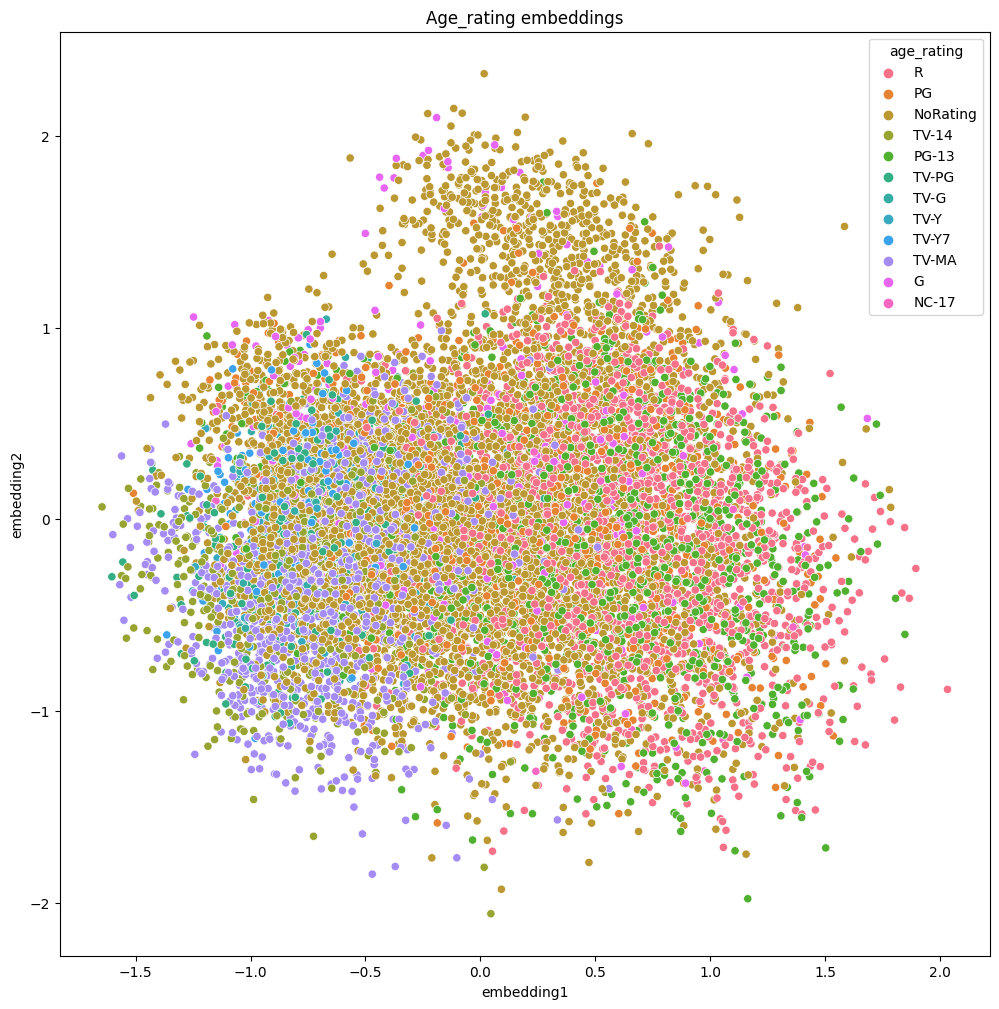

In [ ]:
plot_clusters("age_rating")

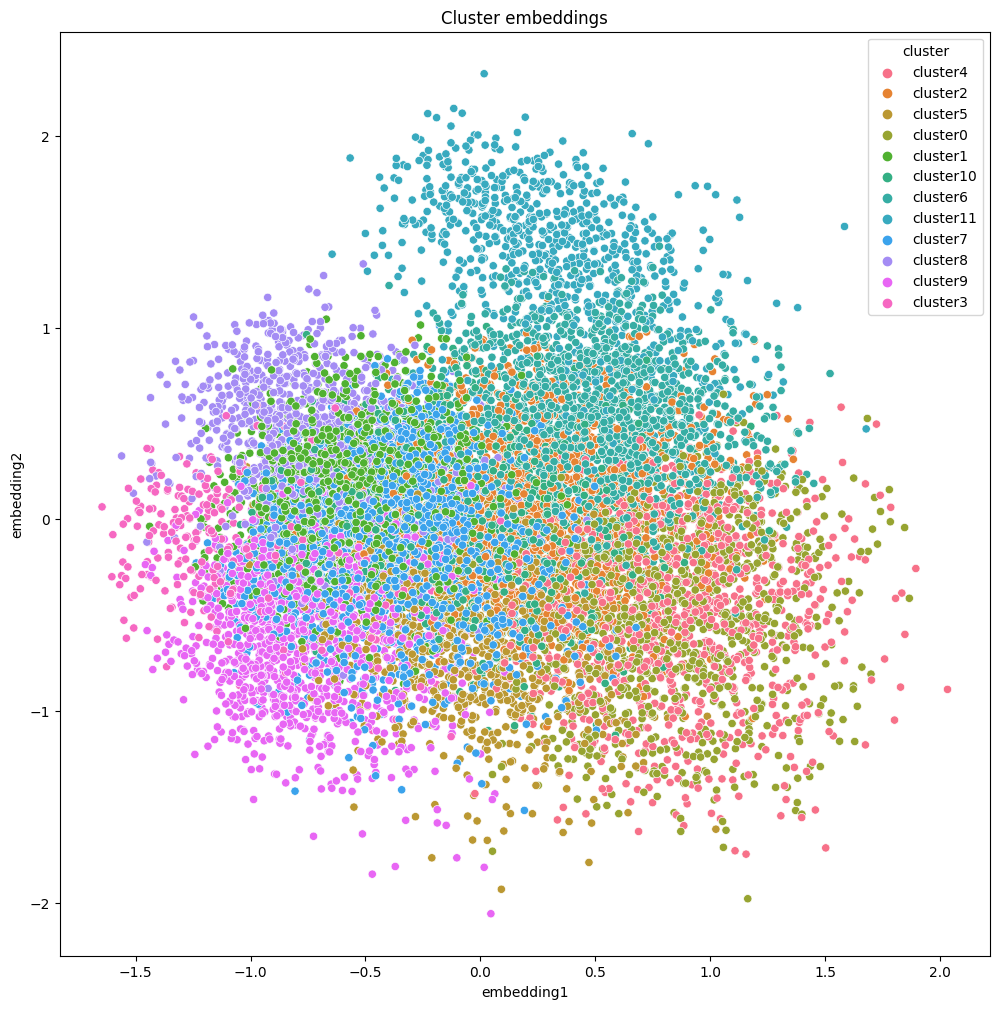

In [ ]:
plot_clusters("cluster")

In [ ]:
from sklearn import metrics
metrics.adjusted_rand_score(plot_df.age_rating, plot_df.cluster)

0.08599235486410829